In [12]:
import sys
from contextlib import contextmanager
import os
@contextmanager
def add_to_path(directory):
    sys.path.append(directory)
    try:
        yield
    finally:
        sys.path.remove(directory)


# curr_file_path = os.path.dirname(os.path.abspath(__file__))
curr_file_path = '/home/kaleb/Documents/GitHub/BrainControlledWheelchair/EEG_ML/tests'
dir_above = os.path.dirname(curr_file_path)
with add_to_path(dir_above):
    from EEGModels import EEGNet
    import read_edf_files as ref

import pandas as pd
import numpy as np
import itertools

from tensorflow.keras import utils as np_utils
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.model_selection import train_test_split
from keras.models import load_model

from brainflow.board_shim import BoardShim, BrainFlowInputParams, BoardIds
from brainflow.data_filter import DataFilter, FilterTypes, NoiseTypes
from sklearn.metrics import confusion_matrix
import seaborn as sns

import matplotlib.pyplot as plt

In [13]:
def get_confusion_matrix(model, x, y):
    # send through the model
    probs = model.predict(x)
    # change from one hot encoded to int
    y_int = y.argmax(axis=1)
    preds = probs.argmax(axis=-1)
    # return cm
    return confusion_matrix(y_int, preds)

In [18]:
def get_trained_model(X, Y, dropoutRate=0.5, kernels=1, kernLength=32, F1=8, D=2, F2=16, batch_size=16, epochs=30):
    half = int(len(X) / 2)
    quarter = int(half / 2)
    three_fourths = half + quarter

    X_train = X[:half, :, :]
    X_validate = X[half: three_fourths, :, :]
    X_test = X[three_fourths:, :, :]

    y_train = Y[:half]
    y_validate = Y[half:three_fourths]
    y_test = Y[three_fourths:]

    # convert labels to one-hot encoding
    y_train = np_utils.to_categorical([x - 1 for x in y_train])
    y_validate = np_utils.to_categorical([x - 1 for x in y_validate])
    y_test = np_utils.to_categorical([x - 1 for x in y_test])

    # convert data to NHWC (trials, channels, samples, kernels) format
    X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2], kernels)
    X_validate = X_validate.reshape(X_validate.shape[0], X_validate.shape[1], X_validate.shape[2], kernels)
    X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2], kernels)

    print('x_train shape: ', X_train.shape, '\ny_train shape: ', y_train.shape)
    ################################################################
    ## Call EEGNet
    model = EEGNet(nb_classes=5, Chans=X_train.shape[1], Samples=X_train.shape[2],
                   dropoutRate=dropoutRate, kernLength=kernLength, F1=F1, D=D, F2=F2,
                   dropoutType='Dropout')

    # compile the model and set the optimizers
    model.compile(loss='categorical_crossentropy', optimizer='adam',
                  metrics=['accuracy'])

    # set a valid path for your system to record model checkpoints
    chkpt_filepath = '/home/kaleb/tmp/checkpoint.h5'
    checkpointer = ModelCheckpoint(filepath=chkpt_filepath, verbose=1,
                                   save_best_only=True)
    # the syntax is {class_1:weight_1, class_2:weight_2,...}. Here just setting
    # the weights all to be 1
    class_weights = {0: 1, 1: 1, 2: 1, 3: 1, 4: 1}
    history = model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs,
              verbose=2, validation_data=(X_validate, y_validate),
              callbacks=[checkpointer], class_weight=class_weights)

    return model, X_test, y_test, history


def get_model_acc(trained_model, X_test, Y_test):
    probs = trained_model.predict(X_test)
    preds = probs.argmax(axis=-1)
    acc = np.mean(preds == Y_test.argmax(axis=-1))

    return acc

In [19]:
# use subject 13, split by second, to get a confusion matrix and show the 
# improvement of the classification score through the epochs
X, Y = ref.reader(passed_path='/home/kaleb/Documents/eeg_dataset/files/', patient_num=13)
X, Y = ref.split_by_second(X, Y, sample_rate=160, num_channels=64)

# shuffle the data
combined_data = list(zip(X, Y))
np.random.shuffle(combined_data)
X_shuf, Y_shuf = zip(*combined_data)
X = np.array(X_shuf)
Y = np.array(Y_shuf)
model, x_test, y_test, history = get_trained_model(X, Y, 0.5, 1, 32, 8, 2, 32, 8, 150)

acc = get_model_acc(model, x_test, y_test)
cm = get_confusion_matrix(model, x_test, y_test)

x_train shape:  (360, 64, 160, 1) 
y_train shape:  (360, 5)
Epoch 1/150


2023-11-21 15:28:17.192942: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_4/dropout_8/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer



Epoch 1: val_loss improved from inf to 1.55952, saving model to /home/kaleb/tmp/checkpoint.h5
45/45 - 1s - loss: 1.5211 - accuracy: 0.4083 - val_loss: 1.5595 - val_accuracy: 0.4833 - 1s/epoch - 24ms/step
Epoch 2/150

Epoch 2: val_loss improved from 1.55952 to 1.47306, saving model to /home/kaleb/tmp/checkpoint.h5
45/45 - 0s - loss: 1.3688 - accuracy: 0.5083 - val_loss: 1.4731 - val_accuracy: 0.4889 - 160ms/epoch - 4ms/step
Epoch 3/150


/home/kaleb/miniconda3/envs/eegnet/lib/python3.9/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(



Epoch 3: val_loss improved from 1.47306 to 1.38199, saving model to /home/kaleb/tmp/checkpoint.h5
45/45 - 0s - loss: 1.2388 - accuracy: 0.5306 - val_loss: 1.3820 - val_accuracy: 0.5000 - 156ms/epoch - 3ms/step
Epoch 4/150

Epoch 4: val_loss improved from 1.38199 to 1.28107, saving model to /home/kaleb/tmp/checkpoint.h5
45/45 - 0s - loss: 1.1490 - accuracy: 0.5917 - val_loss: 1.2811 - val_accuracy: 0.5000 - 160ms/epoch - 4ms/step
Epoch 5/150

Epoch 5: val_loss improved from 1.28107 to 1.25965, saving model to /home/kaleb/tmp/checkpoint.h5
45/45 - 0s - loss: 1.1077 - accuracy: 0.5806 - val_loss: 1.2596 - val_accuracy: 0.5278 - 175ms/epoch - 4ms/step
Epoch 6/150

Epoch 6: val_loss improved from 1.25965 to 1.22641, saving model to /home/kaleb/tmp/checkpoint.h5
45/45 - 0s - loss: 1.1222 - accuracy: 0.5861 - val_loss: 1.2264 - val_accuracy: 0.5278 - 152ms/epoch - 3ms/step
Epoch 7/150

Epoch 7: val_loss improved from 1.22641 to 1.21186, saving model to /home/kaleb/tmp/checkpoint.h5
45/45 - 0

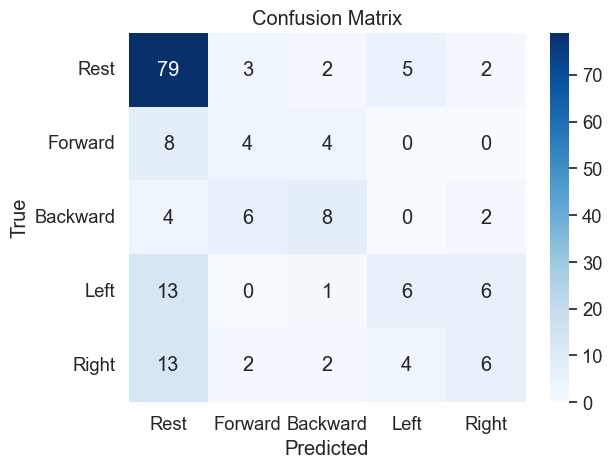

In [20]:
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Rest", "Forward", "Backward", "Left", "Right"],
            yticklabels=["Rest", "Forward", "Backward", "Left", "Right"])
cm_name =  "poster_cm.png"
sns.set(font_scale=1.2)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
output_path = os.path.join(curr_file_path, 'test_data', cm_name)
plt.savefig(output_path, dpi=300)

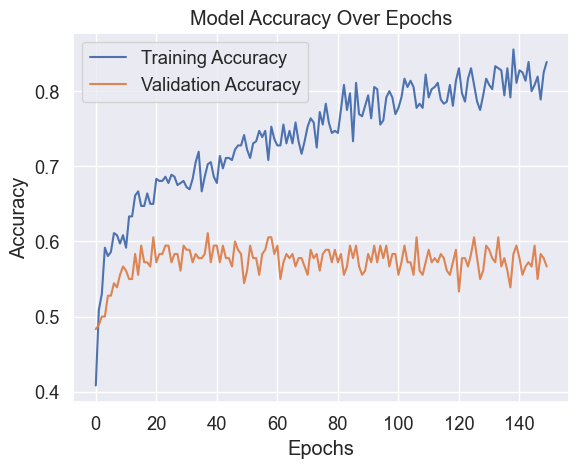

In [25]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()